In [1]:
# Import and Params
import datetime
import numpy as np
import pandas as pd
import datetime
import h3
from pyspark.sql import functions as F, Window
from pyspark.sql.types import DoubleType
from pyspark.sql.types import StringType
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
from scipy import linalg as LA

CITY = "Warsaw"
WINDOW_SIZE = "3 hours"
DATE_FROM = "2022-01-01"
DATE_TO = "2022-05-01"
HEXAGON_RESOLUTION = 7
MOST_ACTIVE_N = 100
%matplotlib inline


ModuleNotFoundError: No module named 'h3'

In [2]:
def h3_res(x):
    return h3.geo_to_h3(float(x.split(",")[0]),float(x.split(",")[1]), HEXAGON_RESOLUTION)

def _clip(value, upper):
  return np.clip(value, 0, upper)
  
def get_data():
  # pickling
  fname = f"./data/combined_quote{CITY}_{DATE_FROM}_{DATE_TO}.pickle"

  df_file = Path(fname)
  if df_file.is_file():
      df = pd.read_pickle(fname)
  else:
      df = aggregated_df.toPandas()
      df.to_pickle(fname)
  df = df.drop(columns=['window_end'])
  return df

def take_most_active(df,n=100):
  # Select N most active hexagons
  valid_hexagons = df.groupby('hexagon').sum().sort_values(['created_quotes'],ascending=False).iloc[:n,:].index  
  df_clean = df.loc[df['hexagon'].isin(valid_hexagons)]
  return df_clean
  
def remove_nans(df):
  df = df.fillna(method='ffill')
  return df

def map_row_format(df):
  # we need to have a matrix organized as (samples, maps)
  # make each row a single map
  df = df.set_index(['hexagon','window_start'])
  df = df.unstack(-1,fill_value=0).T
  df = df.droplevel(0)
  return df

def column_format(df):
  return df.unstack(-1).reset_index().rename(columns={0:'quotes'})

def enrich_features(df):
   # add hour chunk and week day
  df['hour'] = df['window_start'].dt.hour / 3
  df['dow'] = df['window_start'].dt.dayofweek
  df = df.drop(columns=['window_start'])
  if df.columns.isin(['level_0']).any():
    df = df.rename(columns={'level_0':'hexagon'})
  return df

def reduce_dimensionality(df, n_comp=15,plot_requested=True):

  pca = PCA(n_components=n_comp, whiten=False)
  pca.fit(df)
  df_reduced = pd.DataFrame(data=pca.fit_transform(df),
                            index=df.index)
  if plot_requested:
    fig,ax = plt.subplots(3,1,figsize=(8,17))
    sns.heatmap(df,vmin=0, vmax=400,ax=ax[0])
    ax[1].plot(np.cumsum(pca.explained_variance_)/pca.explained_variance_.sum(),marker='o')
    sns.heatmap(df_reduced,vmin=0, vmax=3,ax=ax[2])
    display(fig)
  return df_reduced, pca

def reduce_dimensionality_(df, n_comp=15,plot_requested=True):
  #convenience method that only returns the df
  return reduce_dimensionality(df, n_comp=15,plot_requested=False)[0]

def get_train_test(df):
  f = 'quotes ~ C(hour) + C(dow) + C(hexagon)'
  y, X = patsy.dmatrices(f, df, return_type='dataframe')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, y_train, X_test, y_test

def pca_custom(df, n=15, plot_requested=False):
  x = df.values
  cov = np.cov(x, rowvar = False)
  evals , evecs = LA.eigh(cov)
  idx = np.argsort(evals)[::-1]
  evecs = evecs[:,idx[:n]]
  evals = evals[idx[:n]]
  a = np.dot(x, evecs)
  df_reduced = pd.DataFrame(a,index=df.index)
  if plot_requested:
    fig,ax = plt.subplots(3,1,figsize=(8,17))
    sns.heatmap(df,ax=ax[0])
    ax[1].plot(np.cumsum(evals)/np.sum(evals),marker='o')
    sns.heatmap(df_reduced,ax=ax[2])
    display(fig)
  return df_reduced

NameError: name 'F' is not defined

# Preprocessing

In [0]:
df = get_data()
df = take_most_active(df,n=100)
df = map_row_format(df)
df = remove_nans(df)
df = pca_custom(df)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
window_start,,,,,,,,,,,,,,,
2022-01-01 00:00:00,-2198.007805,-348.902328,-473.718597,-138.348218,137.978458,58.476813,141.848337,63.488344,-14.853269,14.838101,-91.229713,-1.001499,66.960412,-20.365420,14.867952
2022-01-01 03:00:00,-1054.002202,-18.592322,-211.485599,-74.106994,2.929292,15.931732,18.888139,43.969042,22.766205,0.296509,-39.380993,62.251694,-2.096598,-7.858367,3.709746
2022-01-01 06:00:00,-238.473103,-7.001731,-35.225145,-12.290019,-4.304601,1.679610,-2.660090,6.774689,0.932222,4.067619,-13.394008,25.379161,-11.830739,1.690962,-6.321877
2022-01-01 09:00:00,-324.142166,-77.587040,-41.692659,-34.098469,-7.018401,11.640319,27.278860,-15.175636,-5.085527,1.852494,-11.010299,-4.442304,5.943843,3.280908,-10.687133
2022-01-01 12:00:00,-481.735152,-130.335638,-33.243297,-52.172416,19.941455,28.721641,-3.524194,-10.890028,-14.523082,2.521069,10.496535,4.185807,25.019409,11.706661,9.698841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01 09:00:00,-427.428478,-89.412621,-11.203032,-56.890371,6.095775,-9.806565,-9.067290,-23.252745,-9.012706,-2.988754,-4.867820,-0.731281,0.553221,8.354141,15.452625
2022-05-01 12:00:00,-463.304653,-35.675482,-33.634242,-46.670220,-5.553301,-36.363614,8.989837,-11.208551,14.266307,-30.858572,4.770612,-18.049507,8.753163,10.014513,2.657371
2022-05-01 15:00:00,-510.995097,-13.969808,-55.541459,-47.980342,-15.547193,-40.379410,11.161129,6.487753,29.032620,-39.797153,11.646279,-4.632738,-6.470364,18.488154,-11.051308


### Let's fit now a linear model

In [0]:
import statsmodels.formula.api as smf
import patsy
import statsmodels.api as sm

df = get_data()
df = take_most_active(df,n=100)
df = map_row_format(df)
df = remove_nans(df)
df = column_format(df)
df = enrich_features(df)

f = 'quotes ~ C(hour) + C(dow) + C(hexagon)'
y, X = patsy.dmatrices(f, df, return_type='dataframe')

print(sm.OLS(y, X).fit().summary())

OLS Regression Results 
==============================================================================
Dep. Variable: quotes R-squared: 0.681
Model: OLS Adj. R-squared: 0.681
Method: Least Squares F-statistic: 1847.
Date: Wed, 25 May 2022 Prob (F-statistic): 0.00
Time: 21:03:27 Log-Likelihood: -4.6825e+05
No. Observations: 96800 AIC: 9.367e+05
Df Residuals: 96687 BIC: 9.378e+05
Df Model: 112 
Covariance Type: nonrobust 
=================================================================================================
 coef std err t P>|t| [0.025 0.975]
-------------------------------------------------------------------------------------------------
Intercept -17.7790 1.044 -17.032 0.000 -19.825 -15.733
C(hour)[T.1.0] -0.2745 0.393 -0.699 0.484 -1.044 0.495
C(hour)[T.2.0] 22.5135 0.393 57.348 0.000 21.744 23.283
C(hour)[T.3.0] 17.5204 0.393 44.629 0.000 16.751 18.290
C(hour)[T.4.0] 22.0799 0.393 56.243 0.000 21.310 22.849
C(hour)[T.5.0] 30.5291 0.393 77.766 0.000 29.760 31.299
C(hour)[T.6.0] 21.9165 0.393 55.827 0.000 21.147 22.686
C(hour)[T.7.0] 14.1727 0.393 36.102 0.000 13.403 14.942
C(dow)[T.1] 1.9990 0.370 5.398 0.000 1.273 2.725
C(dow)[T.2] 3.0431 0.370 8.218 0.000 2.317 3.769
C(dow)[T.3] 4.0098 0.370 10.829 0.000 3.284 4.736
C(dow)[T.4] 11.3571 0.370 30.670 0.000 10.631 12.083
C(dow)[T.5] 9.7098 0.365 26.594 0.000 8.994 10.425
C(dow)[T.6] -3.3693 0.365 -9.228 0.000 -4.085 -2.654
C(hexagon)[T.871f52244ffffff] 0.2330 1.388 0.168 0.867 -2.487 2.953
C(hexagon)[T.871f52245ffffff] 6.4663 1.388 4.659 0.000 3.746 9.187
C(hexagon)[T.871f52248ffffff] 6.7028 1.388 4.829 0.000 3.982 9.423
C(hexagon)[T.871f52249ffffff] 23.3584 1.388 16.829 0.000 20.638 26.079
C(hexagon)[T.871f5224bffffff] 0.4975 1.388 0.358 0.720 -2.223 3.218
C(hexagon)[T.871f5224cffffff] 12.5746 1.388 9.060 0.000 9.854 15.295
C(hexagon)[T.871f5224dffffff] 31.9500 1.388 23.019 0.000 29.230 34.670
C(hexagon)[T.871f52260ffffff] 21.0531 1.388 15.168 0.000 18.333 23.774
C(hexagon)[T.871f52261ffffff] 42.9456 1.388 30.941 0.000 40.225 45.666
C(hexagon)[T.871f52262ffffff] 17.0249 1.388 12.266 0.000 14.304 19.745
C(hexagon)[T.871f52263ffffff] 12.9137 1.388 9.304 0.000 10.193 15.634
C(hexagon)[T.871f52264ffffff] 17.1149 1.388 12.331 0.000 14.394 19.835
C(hexagon)[T.871f52265ffffff] 44.5743 1.388 32.115 0.000 41.854 47.295
C(hexagon)[T.871f52266ffffff] 9.0737 1.388 6.537 0.000 6.353 11.794
C(hexagon)[T.871f52268ffffff] 86.6381 1.388 62.420 0.000 83.918 89.359
C(hexagon)[T.871f52269ffffff] 59.6187 1.388 42.954 0.000 56.898 62.339
C(hexagon)[T.871f5226affffff] 60.8933 1.388 43.872 0.000 58.173 63.614
C(hexagon)[T.871f5226bffffff] 52.8801 1.388 38.099 0.000 50.160 55.600
C(hexagon)[T.871f5226cffffff] 76.2766 1.388 54.955 0.000 73.556 78.997
C(hexagon)[T.871f5226dffffff] 106.2330 1.388 76.538 0.000 103.513 108.953
C(hexagon)[T.871f5226effffff] 35.9409 1.388 25.894 0.000 33.220 38.661
C(hexagon)[T.871f52275ffffff] 2.8272 1.388 2.037 0.042 0.107 5.548
C(hexagon)[T.871f52348ffffff] 4.9859 1.388 3.592 0.000 2.265 7.706
C(hexagon)[T.871f52349ffffff] 23.4836 1.388 16.919 0.000 20.763 26.204
C(hexagon)[T.871f5234affffff] 4.0317 1.388 2.905 0.004 1.311 6.752
C(hexagon)[T.871f5234bffffff] 41.3193 1.388 29.769 0.000 38.599 44.040
C(hexagon)[T.871f5234dffffff] 12.0754 1.388 8.700 0.000 9.355 14.796
C(hexagon)[T.871f52369ffffff] 0.5926 1.388 0.427 0.669 -2.128 3.313
C(hexagon)[T.871f52ae0ffffff] 2.6059 1.388 1.878 0.060 -0.114 5.326
C(hexagon)[T.871f53504ffffff] -0.2032 1.388 -0.146 0.884 -2.924 2.517
C(hexagon)[T.871f53505ffffff] -0.1961 1.388 -0.141 0.888 -2.916 2.524
C(hexagon)[T.871f53514ffffff] 5.7058 1.388 4.111 0.000 2.985 8.426
C(hexagon)[T.871f53516ffffff] 1.3891 1.388 1.001 0.317 -1.331 4.110
C(hexagon)[T.871f53520ffffff] 2.8136 1.388 2.027 0.043 0.093 5.534
C(hexagon)[T.871f53521ffffff] -0.1697 1.388 -0.122 0.903 -2.890 2.551
C(hexagon)[T.871f53522ffffff] 1.6542 1.388 1.192 0.233 -1.066 4.375
C(hexagon)[T.871f53523ffffff] 0.7324 1.388 0.528 0.598 -1.988 3.453
C(hexagon)[T.871f53524f

In [0]:
import statsmodels.formula.api as smf
import patsy
import statsmodels.api as sm

df = get_data()
df = take_most_active(df,n=100)
df = map_row_format(df)
df = remove_nans(df)
df = pca_custom(df)
df = column_format(df)
df = enrich_features(df)

f = 'quotes ~ C(hour) + C(dow) + C(hexagon)'
y, X = patsy.dmatrices(f, df, return_type='dataframe')

print(sm.OLS(y, X).fit().summary())

OLS Regression Results 
==============================================================================
Dep. Variable: quotes R-squared: 0.711
Model: OLS Adj. R-squared: 0.711
Method: Least Squares F-statistic: 1321.
Date: Wed, 25 May 2022 Prob (F-statistic): 0.00
Time: 21:03:28 Log-Likelihood: -84641.
No. Observations: 14520 AIC: 1.693e+05
Df Residuals: 14492 BIC: 1.695e+05
Df Model: 27 
Covariance Type: nonrobust 
====================================================================================
 coef std err t P>|t| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept -490.1765 3.625 -135.224 0.000 -497.282 -483.071
C(hour)[T.1.0] -1.6037 2.734 -0.586 0.558 -6.964 3.756
C(hour)[T.2.0] -34.3933 2.734 -12.578 0.000 -39.753 -29.033
C(hour)[T.3.0] -24.2563 2.734 -8.871 0.000 -29.616 -18.896
C(hour)[T.4.0] -28.9800 2.734 -10.598 0.000 -34.340 -23.620
C(hour)[T.5.0] -40.1593 2.734 -14.686 0.000 -45.519 -34.799
C(hour)[T.6.0] -27.5782 2.734 -10.086 0.000 -32.938 -22.218
C(hour)[T.7.0] -16.5987 2.734 -6.070 0.000 -21.959 -11.239
C(dow)[T.1] -2.5506 2.579 -0.989 0.323 -7.606 2.505
C(dow)[T.2] -2.9115 2.579 -1.129 0.259 -7.967 2.144
C(dow)[T.3] -4.5616 2.579 -1.769 0.077 -9.617 0.494
C(dow)[T.4] -15.3528 2.579 -5.952 0.000 -20.408 -10.297
C(dow)[T.5] -14.2838 2.543 -5.617 0.000 -19.269 -9.299
C(dow)[T.6] 1.8510 2.543 0.728 0.467 -3.134 6.836
C(hexagon)[T.1] 471.3751 3.744 125.892 0.000 464.036 478.714
C(hexagon)[T.2] 512.3555 3.744 136.837 0.000 505.016 519.695
C(hexagon)[T.3] 497.0268 3.744 132.743 0.000 489.688 504.366
C(hexagon)[T.4] 511.9410 3.744 136.726 0.000 504.602 519.280
C(hexagon)[T.5] 515.8023 3.744 137.757 0.000 508.463 523.142
C(hexagon)[T.6] 519.7380 3.744 138.808 0.000 512.399 527.077
C(hexagon)[T.7] 513.8996 3.744 137.249 0.000 506.560 521.239
C(hexagon)[T.8] 518.3745 3.744 138.444 0.000 511.035 525.714
C(hexagon)[T.9] 516.7828 3.744 138.019 0.000 509.444 524.122
C(hexagon)[T.10] 516.0166 3.744 137.815 0.000 508.677 523.356
C(hexagon)[T.11] 517.9550 3.744 138.332 0.000 510.616 525.294
C(hexagon)[T.12] 517.4545 3.744 138.199 0.000 510.115 524.794
C(hexagon)[T.13] 519.7578 3.744 138.814 0.000 512.418 527.097
C(hexagon)[T.14] 515.7308 3.744 137.738 0.000 508.392 523.070
==============================================================================
Omnibus: 8676.253 Durbin-Watson: 0.823
Prob(Omnibus): 0.000 Jarque-Bera (JB): 1177017.348
Skew: -1.895 Prob(JB): 0.00
Kurtosis: 46.944 Cond. No. 17.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

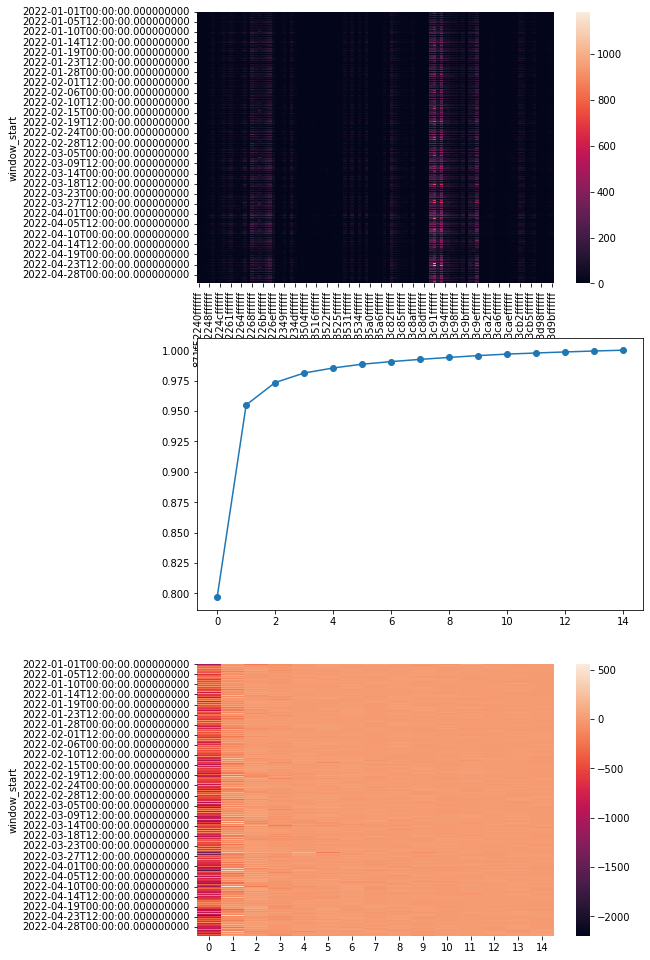

In [0]:
# show the maps
df = get_data()
df = take_most_active(df)
df = remove_nans(df)
df = map_row_format(df)
df = pca_custom(df,plot_requested=True)

# Design and Train Network

In [0]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers

EPOCHS = 1000
VALIDATION_SPLIT = 0.2
VERBOSE = True

  
def linear_model():
  model = Sequential()
  model.add(layers.InputLayer(input_shape=28))
  model.add(Dense(units=1,activation='linear',use_bias=False))
  model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model



pipeline = {0: #one-layer, ie logistric regression w
                  {'data_loader'  : get_data,
                   'preprocessors': [take_most_active, map_row_format, remove_nans, pca_custom, column_format, enrich_features],
                   'splitter'     : get_train_test,
                   'model'        : linear_model,
                }
            }

for i in pipeline.keys():
    data = pipeline[i]['data_loader']()
    
    for p_fun in pipeline[i]['preprocessors']:
        data = p_fun(data)

    X_train, y_train, X_test, y_test = pipeline[i]['splitter'](data)
    
#     kwargs  = pipeline[i]['model_args']
    model = pipeline[i]['model']()
    model.summary()    

    # Training the model.
    history = model.fit(X_train, y_train,
              epochs=EPOCHS,
              verbose=VERBOSE, 
              validation_split=VALIDATION_SPLIT)

#     #evaluate the model
#     test_loss, test_acc = model.evaluate(X_test, Y_test)
#     print('Test accuracy:', test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type) Output Shape Param # 
=================================================================
 dense_1 (Dense) (None, 1) 28 
 
=================================================================
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
 1/291 [..............................] - ETA: 5:39 - loss: 27366.1523 - mse: 27366.1523 72/291 [======>.......................] - ETA: 0s - loss: 27335.6230 - mse: 27335.6230 146/291 [==============>...............] - ETA: 0s - loss: 25704.7754 - mse: 25704.7754221/291 [=====================>........] - ETA: 0s - loss: 25022.0273 - mse: 25022.0273291/291 [==============================] - 2s 1ms/step - loss: 23755.1855 - mse: 23755.1855 - val_loss: 27289.1035 - val_mse: 27289.1035
Epoch 2/1000
 1/291 [..............................] - ETA: 0s - loss: 19352.4199 - mse: 19352.4199 78/291 [=======>......................] - ETA: 0s - loss: 23193.2461 - mse: 23193.2461156/291 [===============>..............] - ETA: 0s - loss: 23400.7559 - mse: 23400.7559234/291 [=======================>......] - ETA: 0s - loss: 22887.9961 - mse: 22887.9961291/291 [==============================] - 0s 834us/step - loss: 23716.9590 - mse: 23716.9590 - val_loss: 27247.4531 - val_mse: 27247.4531
Epoch 3/1000
 1/291 [..............................] - ETA: 0s - loss: 26894.8887 - mse: 26894.8887 76/291 [======>.......................] - ETA: 0s - loss: 22089.7871 - mse: 22089.7871153/291 [==============>...............] - ETA: 0s - loss: 22621.1855 - mse: 22621.1855231/291 [======================>.......] - ETA: 0s - loss: 23972.4434 - mse: 23972.4434291/291 [==============================] - 0s 845us/step - loss: 23679.0781 - mse: 23679.0781 - val_loss: 27207.4277 - val_mse: 27207.4277
Epoch 4/1000
 1/291 [..............................] - ETA: 0s - loss: 27155.2578 - mse: 27155.2578 74/291 [======>.......................] - ETA: 0s - loss: 23402.7480 - mse: 23402.7480149/291 [==============>...............] - ETA: 0s - loss: 24119.1562 - mse: 24119.1562225/291 [======================>.......] - ETA: 0s - loss: 22773.5684 - mse: 22773.5684291/291 [==============================] - 0s 862us/step - loss: 23642.0879 - mse: 23642.0879 - val_loss: 27167.8789 - val_mse: 27167.8789
Epoch 5/1000
 1/291 [..............................] - ETA: 0s - loss: 1104.8746 - mse: 1104.8746

--------------------------------------------------------------------------- 
 RuntimeError Traceback (most recent call last)
 /databricks/python/lib/python3.7/site-packages/IPython/core/completer.py in _complete (self, cursor_line, cursor_pos, line_buffer, text, full_text) 
 2032 try : 
 2033 matches.extend([(m, matcher.__qualname__)
 -> 2034 for m in matcher(text)])
 2035 except : 
 2036 # Show the ugly traceback if the matcher causes an 

 /databricks/python/lib/python3.7/site-packages/IPython/core/completer.py in python_matches (self, text) 
 1421 matches = [ ] 
 1422 else : 
 -> 1423 matches = self . global_matches ( text ) 
 1424 return matches
 1425 

 /local_disk0/tmp/1653509276736-0/RichCompleter.py in global_matches (self, text) 
 69 # parsing the docstring because C-built functions don't give argspecs in Python. 
 70 for d in [ builtin_mod . __dict__ , self . namespace , self . global_namespace ] : 
 ---> 71 for word in d . keys ( ) : 
 72 if word [ : n ] == text and word != "__builtins__" : 
 73 obj = d [ word ] 

 RuntimeError : dictionary changed size during iteration

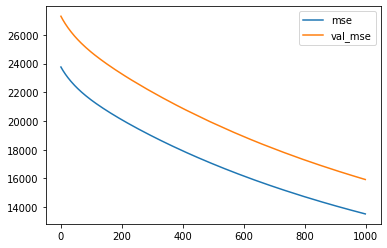

In [0]:
display(pd.DataFrame(history.history)[['mse','val_mse']].plot())

# SHOW RESULTS

In [0]:
y_train['fitted'] = model.predict(X_train)
y_train.corr()

,quotes,fitted
quotes,1.00000,0.73981
fitted,0.73981,1.00000


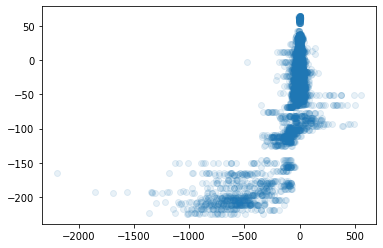

In [0]:
y_hat = model.predict(X_train)
fig, ax = plt.subplots(1,1)
ax.scatter(y_train.quotes,y_train.fitted, marker='o', alpha=.1)
display(ax)

# Visualize Results as Maps

In [0]:
%python
from keplergl import KeplerGl
bla = df_clean.set_index('hexagon')['created_quotes'].to_frame()
kmap = KeplerGl(data={"data_1": bla} )

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-717213374901248> in <module> 
 1 from keplergl import KeplerGl
 ----> 2 bla = df_clean . set_index ( 'hexagon' ) [ 'created_quotes' ] . to_frame ( ) 
 3 kmap = KeplerGl ( data = { "data_1" : bla } ) 

 NameError : name 'df_clean' is not defined

In [0]:
import keplergl
import tempfile
 
orig_repr_html_ = keplergl.KeplerGl._repr_html_
def html_patch(self):
  """This is the patch to make it work well in Databricks"""
  # temp file purposely doesn't get cleaned up, but should if that's desired
  (_, tmp) = tempfile.mkstemp() 
  frame_bytes = orig_repr_html_(self)
  frame_str = str(frame_bytes, encoding='utf-8')
  # This additional script for fixing the height is necessary because kepler doesn't embed well, and
  # mutates containing document directly. The height parameter to keplergl.KeplerGl will be the initial 
  # height of the result iframe. 
  return f"""{frame_str}<script>
    var targetHeight = "{self.height or 600}px";
    var interval = window.setInterval(function() {{
      if (document.body && document.body.style && document.body.style.height !== targetHeight) {{
        document.body.style.height = targetHeight;
      }}
    }}, 250);</script>""";
setattr(keplergl.KeplerGl, '_repr_html_', html_patch)

In [0]:
map_1 = keplergl.KeplerGl(data={"data_1": df_clean.loc[:,['hexagon','created_quotes']]},height=600)
 
displayHTML(map_1._repr_html_())

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-717213374901250> in <module> 
 ----> 1 map_1 = keplergl . KeplerGl ( data = { "data_1" : df_clean . loc [ : , [ 'hexagon' , 'created_quotes' ] ] } , height = 600 ) 
 2 
 3 displayHTML ( map_1 . _repr_html_ ( ) ) 

 NameError : name 'df_clean' is not defined

,hexagon,created_quotes
5,871f53c98ffffff,101.111111
8,871f53530ffffff,135.888889
9,871f53c8cffffff,78.444444
19,871f53cb1ffffff,43.222222
23,871f52249ffffff,61.777778
...,...,...
115893,871f53534ffffff,1.111111
115894,871f53c8dffffff,0.777778
115899,871f53c8cffffff,1.333333
115921,871f5226bffffff,8.888889
